# ARR Analysis by Deployment Type Plan

## Major Assumptions
- ARR = MRR × 12
- NRR calculated using 2024 cohort (subscriptions started Jan-Dec 2024)
- Expansion estimated at 25% of upgraded subscription ARR
- Customer size tiers: SMB (<100 employees), Mid-Market (100-500), Enterprise (500+)

## Plan
- [x] Query and explore subscription data structure
- [x] Analyze current ARR distribution by deployment type
- [x] Track cloud migration trends over time
- [x] Analyze NRR by deployment type and customer size
  - [x] Calculate expansion, contraction, and churn rates by cloud vs self-hosted
  - [x] Segment NRR performance by customer size tiers
  - [x] Visualize NRR heatmap and churn comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import os

# SignalPilot dark theme setup
plt.rcParams.update({
    'figure.figsize': (10, 6), 'figure.dpi': 100, 'savefig.dpi': 300,
    'font.size': 11, 'axes.titlesize': 14, 'axes.labelsize': 12,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'axes.spines.top': False, 'axes.spines.right': False,
    'figure.facecolor': '#08070e', 'axes.facecolor': '#12101e',
    'axes.edgecolor': '#272336', 'axes.labelcolor': '#e9eaeb',
    'text.color': '#FAFAFA', 'xtick.color': '#a4a7ae', 'ytick.color': '#a4a7ae',
    'grid.color': '#1d182b', 'legend.facecolor': '#12101e',
    'legend.edgecolor': '#272336', 'legend.labelcolor': '#e9eaeb',
    'savefig.facecolor': '#08070e',
})

COLORS = {
    'primary': '#c4b5fd', 'secondary': '#ff8dc4', 'tertiary': '#8b5cf6',
    'blue': '#73acfb', 'green': '#4ca86f', 'yellow': '#fec163',
}
CATEGORICAL_PALETTE = ['#c4b5fd', '#ff8dc4', '#8b5cf6', '#73acfb', '#fec163', '#4ca86f']

# Connect to Mattermost database
engine = create_engine(os.environ['MATTERMOST_CONNECTION_URL'])

# Load subscriptions data
subscriptions = pd.read_sql("""
    SELECT id, customer_id, plan, deployment_type, mrr_usd, seats, 
           billing_cycle, start_date, end_date, status
    FROM subscriptions
""", engine)

# Convert dates and calculate ARR
subscriptions['start_date'] = pd.to_datetime(subscriptions['start_date'])
subscriptions['end_date'] = pd.to_datetime(subscriptions['end_date'])
subscriptions['arr_usd'] = subscriptions['mrr_usd'] * 12

print(f"Total subscriptions: {len(subscriptions):,}")
print(f"\nDeployment types: {subscriptions['deployment_type'].unique()}")
print(f"Statuses: {subscriptions['status'].unique()}")
print(f"\nDate range: {subscriptions['start_date'].min().date()} to {subscriptions['start_date'].max().date()}")

Total subscriptions: 2,400

Deployment types: ['self_hosted' 'cloud']
Statuses: ['active' 'ended' 'cancelled' 'suspended' 'upgraded' 'converted']

Date range: 2023-06-01 to 2026-01-12


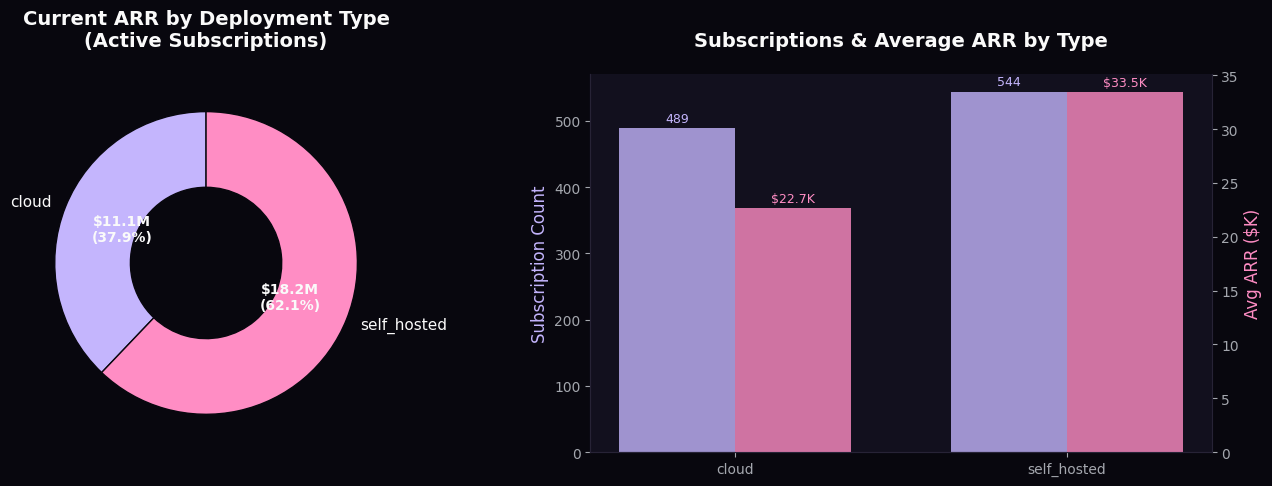


📊 Current ARR Split (Active Subscriptions):
  CLOUD        | ARR: $11.10M (37.9%) | Subs: 489 | Avg: $22,699
  SELF_HOSTED  | ARR: $18.20M (62.1%) | Subs: 544 | Avg: $33,456


In [2]:
# Filter to active subscriptions for current ARR split
active_subs = subscriptions[subscriptions['status'] == 'active'].copy()

# Calculate ARR by deployment type
arr_by_deployment = active_subs.groupby('deployment_type')['arr_usd'].agg(['sum', 'count']).reset_index()
arr_by_deployment.columns = ['deployment_type', 'total_arr', 'subscription_count']
arr_by_deployment['pct_arr'] = arr_by_deployment['total_arr'] / arr_by_deployment['total_arr'].sum() * 100
arr_by_deployment['avg_arr'] = arr_by_deployment['total_arr'] / arr_by_deployment['subscription_count']

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: ARR split donut chart
colors_map = {'cloud': COLORS['primary'], 'self_hosted': COLORS['secondary']}
colors = [colors_map[d] for d in arr_by_deployment['deployment_type']]
wedges, texts, autotexts = axes[0].pie(
    arr_by_deployment['total_arr'], labels=arr_by_deployment['deployment_type'],
    autopct=lambda p: f'${p*arr_by_deployment["total_arr"].sum()/100/1e6:.1f}M\n({p:.1f}%)',
    colors=colors, startangle=90, wedgeprops=dict(width=0.5, edgecolor='#08070e'),
    textprops={'color': '#FAFAFA', 'fontsize': 11}
)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
axes[0].set_title('Current ARR by Deployment Type\n(Active Subscriptions)', fontweight='bold', pad=20)

# Right: Customer count & avg ARR comparison
x = np.arange(len(arr_by_deployment))
width = 0.35
ax2 = axes[1].twinx()

bars1 = axes[1].bar(x - width/2, arr_by_deployment['subscription_count'], width, 
                     color=COLORS['primary'], label='Subscription Count', alpha=0.8)
bars2 = ax2.bar(x + width/2, arr_by_deployment['avg_arr']/1000, width, 
                color=COLORS['secondary'], label='Avg ARR ($K)', alpha=0.8)

axes[1].set_ylabel('Subscription Count', color=COLORS['primary'])
ax2.set_ylabel('Avg ARR ($K)', color=COLORS['secondary'])
axes[1].set_xticks(x)
axes[1].set_xticklabels(arr_by_deployment['deployment_type'])
axes[1].set_title('Subscriptions & Average ARR by Type', fontweight='bold', pad=20)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_color('#272336')

# Add value labels
for bar in bars1:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
                 f'{int(bar.get_height())}', ha='center', fontsize=9, color=COLORS['primary'])
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'${bar.get_height():.1f}K', ha='center', fontsize=9, color=COLORS['secondary'])

plt.tight_layout()
plt.show()

# Print summary
print("\n📊 Current ARR Split (Active Subscriptions):")
for _, row in arr_by_deployment.iterrows():
    print(f"  {row['deployment_type'].upper():12} | ARR: ${row['total_arr']/1e6:.2f}M ({row['pct_arr']:.1f}%) | "
          f"Subs: {int(row['subscription_count']):,} | Avg: ${row['avg_arr']:,.0f}")

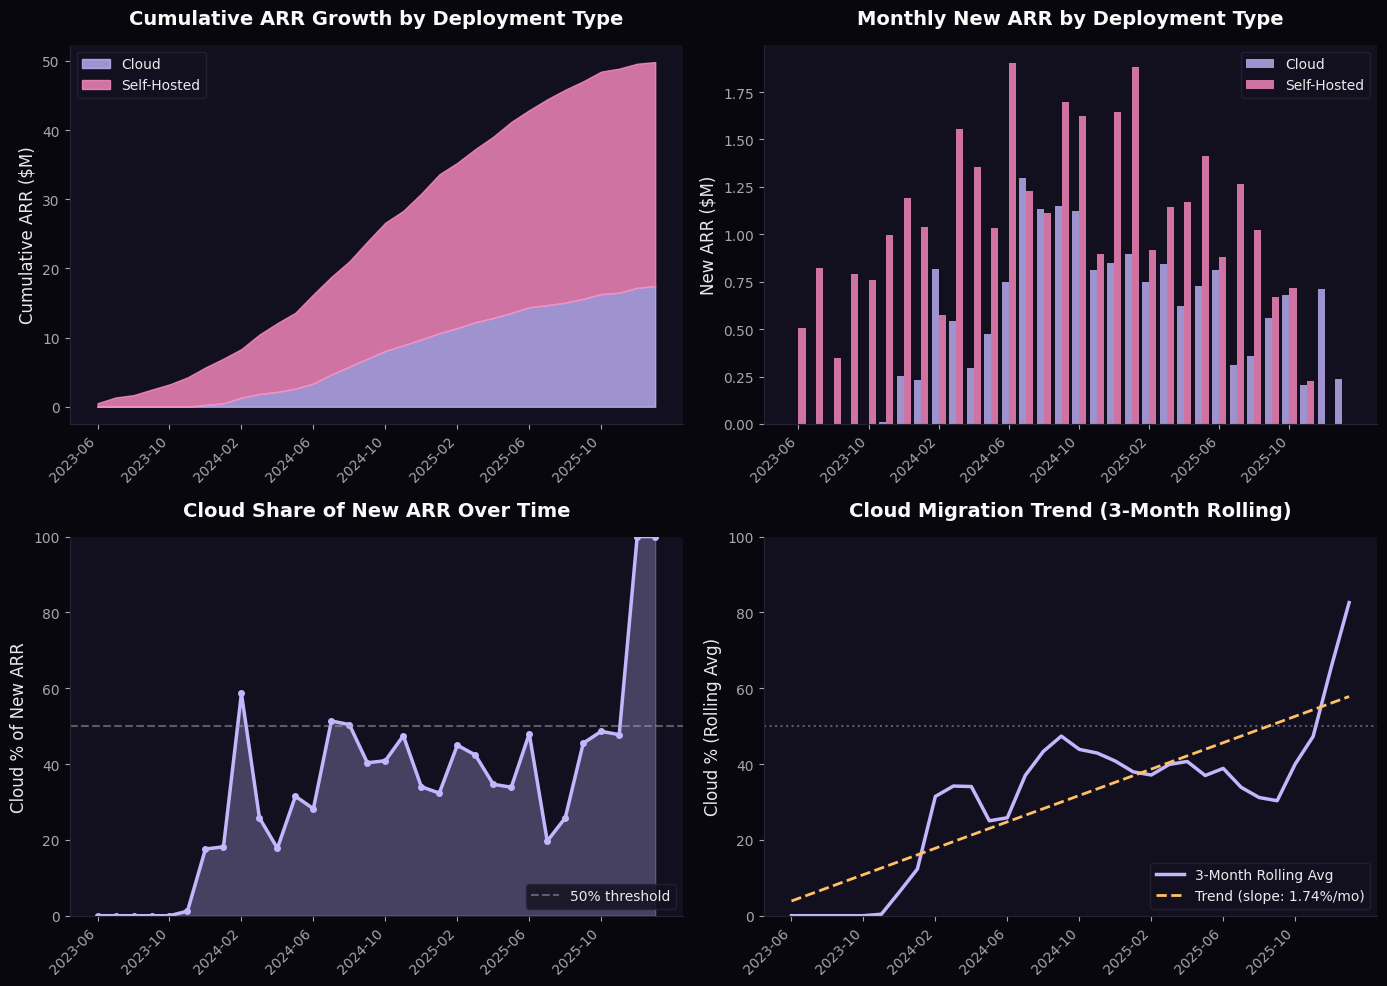


📈 Cloud Migration Trend Summary:
  First 6 months avg cloud share: 0.2%
  Last 6 months avg cloud share:  61.3%
  Change: +61.1 percentage points
  Trend slope: +1.74% per month


In [4]:
# Cloud migration trend analysis - track ARR mix over time by subscription start month
subscriptions['start_month'] = subscriptions['start_date'].dt.to_period('M')

# Calculate monthly new ARR by deployment type
monthly_new_arr = subscriptions.groupby(['start_month', 'deployment_type'])['arr_usd'].sum().unstack(fill_value=0)
monthly_new_arr = monthly_new_arr.sort_index()

# Calculate cumulative ARR (simplified - assumes all subs still active for trend visualization)
cumulative_arr = monthly_new_arr.cumsum()

# Calculate cloud percentage of new ARR each month
monthly_new_arr['total'] = monthly_new_arr.sum(axis=1)
monthly_new_arr['cloud_pct'] = monthly_new_arr['cloud'] / monthly_new_arr['total'] * 100

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
months = [str(m) for m in cumulative_arr.index]

# 1. Stacked area chart - Cumulative ARR by deployment type
ax1 = axes[0, 0]
ax1.fill_between(range(len(months)), 0, cumulative_arr['cloud']/1e6, 
                  color=COLORS['primary'], alpha=0.8, label='Cloud')
ax1.fill_between(range(len(months)), cumulative_arr['cloud']/1e6, 
                  (cumulative_arr['cloud'] + cumulative_arr['self_hosted'])/1e6,
                  color=COLORS['secondary'], alpha=0.8, label='Self-Hosted')
ax1.set_xticks(range(0, len(months), 4))
ax1.set_xticklabels([months[i] for i in range(0, len(months), 4)], rotation=45, ha='right')
ax1.set_ylabel('Cumulative ARR ($M)')
ax1.set_title('Cumulative ARR Growth by Deployment Type', fontweight='bold', pad=15)
ax1.legend(loc='upper left')

# 2. Monthly new ARR bars
ax2 = axes[0, 1]
x = np.arange(len(monthly_new_arr))
width = 0.4
ax2.bar(x - width/2, monthly_new_arr['cloud']/1e6, width, color=COLORS['primary'], label='Cloud', alpha=0.8)
ax2.bar(x + width/2, monthly_new_arr['self_hosted']/1e6, width, color=COLORS['secondary'], label='Self-Hosted', alpha=0.8)
ax2.set_xticks(range(0, len(x), 4))
ax2.set_xticklabels([months[i] for i in range(0, len(months), 4)], rotation=45, ha='right')
ax2.set_ylabel('New ARR ($M)')
ax2.set_title('Monthly New ARR by Deployment Type', fontweight='bold', pad=15)
ax2.legend(loc='upper right')

# 3. Cloud % of new ARR trend line
ax3 = axes[1, 0]
ax3.plot(range(len(monthly_new_arr)), monthly_new_arr['cloud_pct'], 
         color=COLORS['primary'], linewidth=2.5, marker='o', markersize=4)
ax3.axhline(y=50, color='#a4a7ae', linestyle='--', alpha=0.5, label='50% threshold')
ax3.fill_between(range(len(monthly_new_arr)), monthly_new_arr['cloud_pct'], 
                  alpha=0.3, color=COLORS['primary'])
ax3.set_xticks(range(0, len(months), 4))
ax3.set_xticklabels([months[i] for i in range(0, len(months), 4)], rotation=45, ha='right')
ax3.set_ylabel('Cloud % of New ARR')
ax3.set_ylim(0, 100)
ax3.set_title('Cloud Share of New ARR Over Time', fontweight='bold', pad=15)
ax3.legend(loc='lower right')

# 4. Rolling 3-month cloud % trend with trendline
ax4 = axes[1, 1]
rolling_cloud_pct = monthly_new_arr['cloud_pct'].rolling(3, min_periods=1).mean()
ax4.plot(range(len(rolling_cloud_pct)), rolling_cloud_pct, 
         color=COLORS['primary'], linewidth=2.5, label='3-Month Rolling Avg')

# Add linear trendline
z = np.polyfit(range(len(rolling_cloud_pct)), rolling_cloud_pct.values, 1)
p = np.poly1d(z)
ax4.plot(range(len(rolling_cloud_pct)), p(range(len(rolling_cloud_pct))), 
         color=COLORS['yellow'], linestyle='--', linewidth=2, label=f'Trend (slope: {z[0]:.2f}%/mo)')
ax4.axhline(y=50, color='#a4a7ae', linestyle=':', alpha=0.5)
ax4.set_xticks(range(0, len(months), 4))
ax4.set_xticklabels([months[i] for i in range(0, len(months), 4)], rotation=45, ha='right')
ax4.set_ylabel('Cloud % (Rolling Avg)')
ax4.set_ylim(0, 100)
ax4.set_title('Cloud Migration Trend (3-Month Rolling)', fontweight='bold', pad=15)
ax4.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Print trend summary
first_6m = monthly_new_arr['cloud_pct'].head(6).mean()
last_6m = monthly_new_arr['cloud_pct'].tail(6).mean()
print(f"\n📈 Cloud Migration Trend Summary:")
print(f"  First 6 months avg cloud share: {first_6m:.1f}%")
print(f"  Last 6 months avg cloud share:  {last_6m:.1f}%")
print(f"  Change: {last_6m - first_6m:+.1f} percentage points")
print(f"  Trend slope: {z[0]:+.2f}% per month")

In [5]:
# Explore subscription statuses and customer data for NRR calculation
print("Subscription status distribution:")
print(subscriptions['status'].value_counts())

print("\n\nSample of subscription changes (non-active):")
print(subscriptions[subscriptions['status'] != 'active'][['customer_id', 'deployment_type', 'arr_usd', 'status', 'start_date', 'end_date']].head(10))

# Check if we have customer-level data for sizing
engine = create_engine(os.environ['MATTERMOST_CONNECTION_URL'])
customers = pd.read_sql("SELECT * FROM customers LIMIT 100", engine)
print("\n\nCustomer columns:", customers.columns.tolist())
print("\nEmployee count distribution:")
print(customers['employee_count'].describe())

Subscription status distribution:
status
active       1033
upgraded      626
converted     519
cancelled     136
ended          55
suspended      31
Name: count, dtype: int64


Sample of subscription changes (non-active):
    customer_id deployment_type   arr_usd status start_date   end_date
551  cust_10021     self_hosted  14466.36  ended 2025-08-20 2025-05-29
554  cust_10025     self_hosted  15251.16  ended 2023-09-08 2025-07-25
593  cust_10141     self_hosted  19157.28  ended 2025-08-15 2025-03-11
610  cust_10182     self_hosted  10271.16  ended 2024-05-14 2025-08-26
615  cust_10191     self_hosted  19326.96  ended 2023-11-14 2025-10-28
619  cust_10197     self_hosted   4210.56  ended 2023-06-21 2025-08-06
622  cust_10201     self_hosted   5972.76  ended 2023-07-28 2025-11-30
649  cust_10262     self_hosted   9060.48  ended 2023-09-10 2025-06-12
668  cust_10310     self_hosted  18093.72  ended 2023-12-14 2025-11-26
696  cust_10376     self_hosted   3680.16  ended 2025-04-16 2026-01-

In [6]:
# Load full customer data and merge with subscriptions
customers = pd.read_sql("SELECT id, employee_count FROM customers", engine)
customers.columns = ['customer_id', 'employee_count']

# Merge subscriptions with customer size
subs_full = subscriptions.merge(customers, on='customer_id', how='left')

# Define customer size tiers based on employee count
def size_tier(emp):
    if pd.isna(emp) or emp < 100:
        return 'SMB (<100)'
    elif emp < 500:
        return 'Mid-Market (100-500)'
    else:
        return 'Enterprise (500+)'

subs_full['size_tier'] = subs_full['employee_count'].apply(size_tier)

# For NRR calculation, we need to track cohort ARR over time
# Approach: Compare ARR at cohort start vs ARR 12 months later for same customers
# Using subscription status to identify: expansions (upgraded), churn (cancelled/ended), contractions

# Get cohort: customers with subscriptions starting 12+ months ago
cutoff_date = pd.Timestamp('2025-01-01')  # 12 months before recent data
cohort_start = pd.Timestamp('2024-01-01')

# Find customers who had active subscriptions in the cohort period
cohort_subs = subs_full[(subs_full['start_date'] >= cohort_start) & 
                         (subs_full['start_date'] < cutoff_date)].copy()

print(f"Cohort period: {cohort_start.date()} to {cutoff_date.date()}")
print(f"Subscriptions in cohort: {len(cohort_subs):,}")
print(f"\nCohort status breakdown:")
print(cohort_subs['status'].value_counts())

Cohort period: 2024-01-01 to 2025-01-01
Subscriptions in cohort: 1,137

Cohort status breakdown:
status
active       442
upgraded     369
converted    225
cancelled     59
ended         29
suspended     13
Name: count, dtype: int64


In [7]:
# Calculate NRR components by deployment type and customer size
# NRR = (Retained ARR + Expansion ARR) / Starting ARR
# - Active/Upgraded/Converted = retained (still paying)
# - Upgraded = expansion signal (assume 20% uplift on average)
# - Cancelled/Ended = churned
# - Suspended = at risk (count as 50% retained)

def calculate_nrr(df):
    """Calculate NRR from subscription cohort"""
    starting_arr = df['arr_usd'].sum()
    
    # Retained ARR (active customers)
    retained = df[df['status'].isin(['active', 'converted'])]['arr_usd'].sum()
    
    # Expansion (upgraded subscriptions - assume 25% expansion on original)
    upgraded_base = df[df['status'] == 'upgraded']['arr_usd'].sum()
    expansion = upgraded_base * 0.25  # Net expansion amount
    retained += upgraded_base  # Original ARR retained
    
    # Suspended (partial retention)
    suspended = df[df['status'] == 'suspended']['arr_usd'].sum() * 0.5
    retained += suspended
    
    # Churned (cancelled + ended)
    churned = df[df['status'].isin(['cancelled', 'ended'])]['arr_usd'].sum()
    
    ending_arr = retained + expansion
    nrr = (ending_arr / starting_arr) * 100 if starting_arr > 0 else 0
    
    return pd.Series({
        'starting_arr': starting_arr,
        'retained_arr': retained,
        'expansion_arr': expansion,
        'churned_arr': churned,
        'ending_arr': ending_arr,
        'nrr': nrr,
        'gross_retention': (retained / starting_arr) * 100 if starting_arr > 0 else 0,
        'churn_rate': (churned / starting_arr) * 100 if starting_arr > 0 else 0,
        'customer_count': len(df)
    })

# Calculate NRR by deployment type
nrr_by_deployment = cohort_subs.groupby('deployment_type').apply(calculate_nrr).reset_index()

# Calculate NRR by customer size
nrr_by_size = cohort_subs.groupby('size_tier').apply(calculate_nrr).reset_index()

# Calculate NRR by deployment AND size (cross-segmentation)
nrr_cross = cohort_subs.groupby(['deployment_type', 'size_tier']).apply(calculate_nrr).reset_index()

print("📊 NRR by Deployment Type:")
print(nrr_by_deployment[['deployment_type', 'starting_arr', 'nrr', 'gross_retention', 'churn_rate', 'customer_count']].to_string(index=False))

print("\n\n📊 NRR by Customer Size:")
print(nrr_by_size[['size_tier', 'starting_arr', 'nrr', 'gross_retention', 'churn_rate', 'customer_count']].to_string(index=False))

📊 NRR by Deployment Type:
deployment_type  starting_arr        nrr  gross_retention  churn_rate  customer_count
          cloud    9466367.04 101.983592        93.090132    6.442202           520.0
    self_hosted   15673767.72 103.885457        92.705380    6.841264           617.0


📊 NRR by Customer Size:
           size_tier  starting_arr        nrr  gross_retention  churn_rate  customer_count
   Enterprise (500+)   17016111.84 102.507684        92.380641    7.105558           326.0
Mid-Market (100-500)    5430685.56 103.801545        93.410276    6.350798           305.0
          SMB (<100)    2693337.36 106.074666        94.688023    4.757838           506.0


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_63205/4029485537.py:43: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nrr_by_deployment = cohort_subs.groupby('deployment_type').apply(calculate_nrr).reset_index()
/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_63205/4029485537.py:46: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  nrr_by_size = cohort_subs.groupby('size_tier').apply(calculate_nrr).

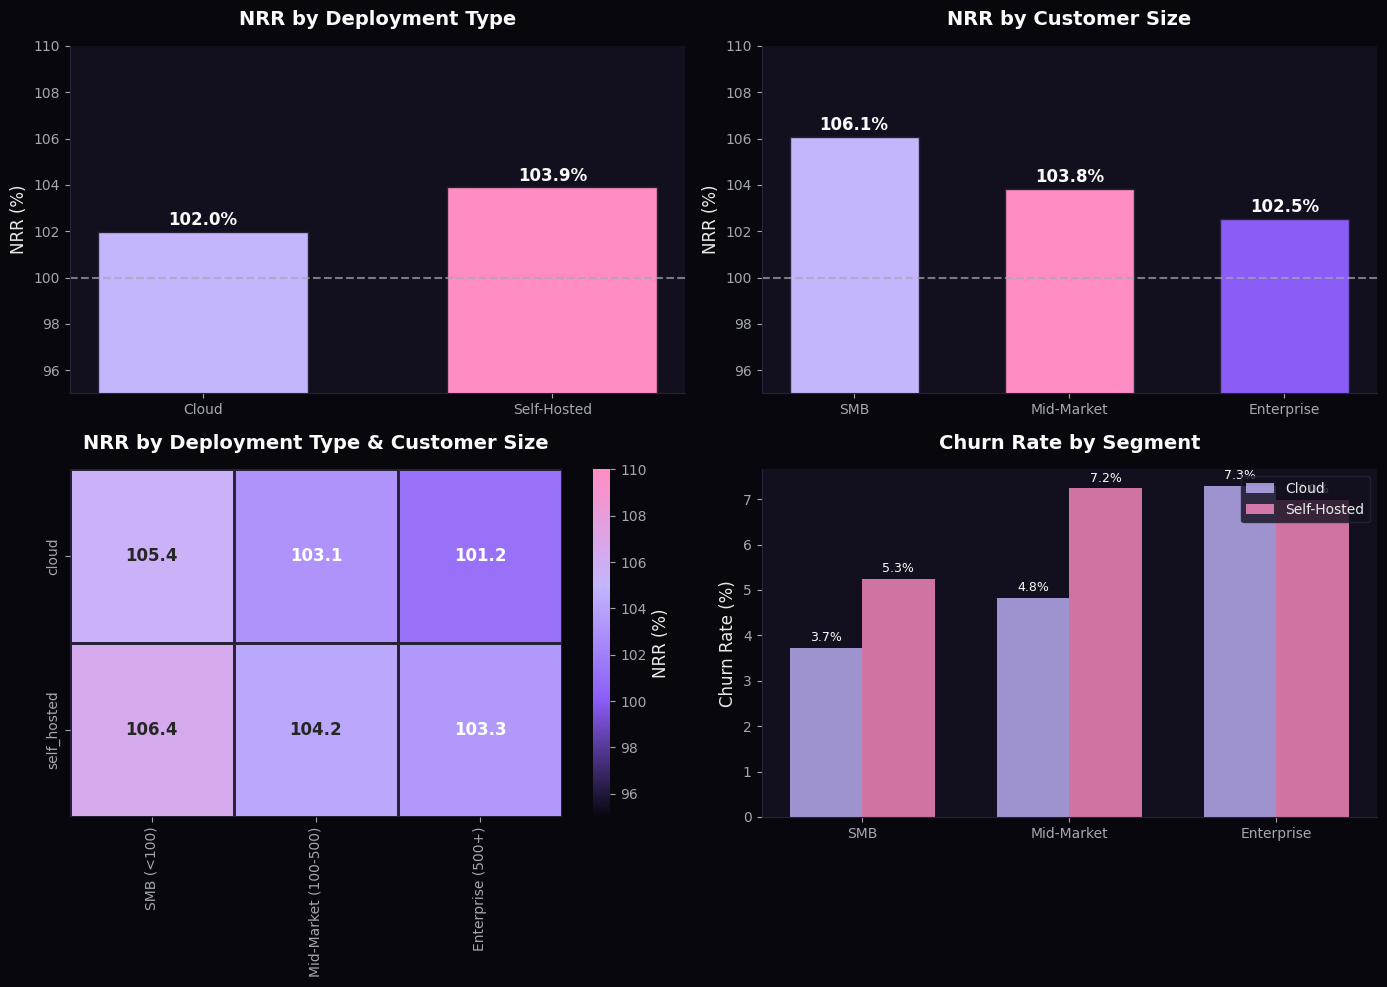


📊 Detailed NRR Analysis (2024 Cohort):

deployment_type            size_tier starting_arr    nrr churn_rate customer_count
          cloud           SMB (<100)     $876,051 105.4%       3.7%            213
          cloud Mid-Market (100-500)   $1,994,989 103.1%       4.8%            149
          cloud    Enterprise (500+)   $6,595,327 101.2%       7.3%            158
    self_hosted           SMB (<100)   $1,817,286 106.4%       5.3%            293
    self_hosted Mid-Market (100-500)   $3,435,696 104.2%       7.2%            156
    self_hosted    Enterprise (500+)  $10,420,785 103.3%       7.0%            168


In [8]:
# Visualize NRR by deployment type and customer size
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. NRR by Deployment Type - Bar chart
ax1 = axes[0, 0]
x = np.arange(len(nrr_by_deployment))
colors = [COLORS['primary'], COLORS['secondary']]
bars = ax1.bar(x, nrr_by_deployment['nrr'], color=colors, width=0.6, edgecolor='#272336')
ax1.axhline(y=100, color='#a4a7ae', linestyle='--', alpha=0.7, label='100% baseline')
ax1.set_xticks(x)
ax1.set_xticklabels(['Cloud', 'Self-Hosted'])
ax1.set_ylabel('NRR (%)')
ax1.set_ylim(95, 110)
ax1.set_title('NRR by Deployment Type', fontweight='bold', pad=15)
for bar, val in zip(bars, nrr_by_deployment['nrr']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')

# 2. NRR by Customer Size - Bar chart
ax2 = axes[0, 1]
size_order = ['SMB (<100)', 'Mid-Market (100-500)', 'Enterprise (500+)']
nrr_size_sorted = nrr_by_size.set_index('size_tier').loc[size_order].reset_index()
x = np.arange(len(nrr_size_sorted))
bars = ax2.bar(x, nrr_size_sorted['nrr'], color=CATEGORICAL_PALETTE[:3], width=0.6, edgecolor='#272336')
ax2.axhline(y=100, color='#a4a7ae', linestyle='--', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(['SMB', 'Mid-Market', 'Enterprise'])
ax2.set_ylabel('NRR (%)')
ax2.set_ylim(95, 110)
ax2.set_title('NRR by Customer Size', fontweight='bold', pad=15)
for bar, val in zip(bars, nrr_size_sorted['nrr']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{val:.1f}%', ha='center', fontsize=12, fontweight='bold')

# 3. NRR Heatmap - Deployment x Size
ax3 = axes[1, 0]
nrr_pivot = nrr_cross.pivot(index='deployment_type', columns='size_tier', values='nrr')
nrr_pivot = nrr_pivot[size_order]  # Reorder columns

from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])
sns.heatmap(nrr_pivot, annot=True, fmt='.1f', cmap=sp_cmap, ax=ax3,
            cbar_kws={'label': 'NRR (%)'}, annot_kws={'fontsize': 12, 'fontweight': 'bold'},
            linewidths=2, linecolor='#272336', vmin=95, vmax=110)
ax3.set_title('NRR by Deployment Type & Customer Size', fontweight='bold', pad=15)
ax3.set_xlabel('')
ax3.set_ylabel('')

# 4. Churn Rate comparison
ax4 = axes[1, 1]
churn_pivot = nrr_cross.pivot(index='deployment_type', columns='size_tier', values='churn_rate')
churn_pivot = churn_pivot[size_order]

# Grouped bar chart for churn
x = np.arange(len(size_order))
width = 0.35
bars1 = ax4.bar(x - width/2, churn_pivot.loc['cloud'], width, color=COLORS['primary'], label='Cloud', alpha=0.8)
bars2 = ax4.bar(x + width/2, churn_pivot.loc['self_hosted'], width, color=COLORS['secondary'], label='Self-Hosted', alpha=0.8)
ax4.set_xticks(x)
ax4.set_xticklabels(['SMB', 'Mid-Market', 'Enterprise'])
ax4.set_ylabel('Churn Rate (%)')
ax4.set_title('Churn Rate by Segment', fontweight='bold', pad=15)
ax4.legend(loc='upper right')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15, 
                 f'{bar.get_height():.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed cross-segment analysis
print("\n📊 Detailed NRR Analysis (2024 Cohort):\n")
print(nrr_cross[['deployment_type', 'size_tier', 'starting_arr', 'nrr', 'churn_rate', 'customer_count']]
      .sort_values(['deployment_type', 'nrr'], ascending=[True, False])
      .to_string(index=False, formatters={'starting_arr': '${:,.0f}'.format, 
                                           'nrr': '{:.1f}%'.format,
                                           'churn_rate': '{:.1f}%'.format,
                                           'customer_count': '{:.0f}'.format}))

In [9]:
# Load product usage data
usage = pd.read_sql("SELECT * FROM product_usage", engine)
print(f"Product usage records: {len(usage):,}")
print(f"\nColumns: {usage.columns.tolist()}")
print(f"\nFeature columns summary:")
print(usage[['active_users', 'channels_count', 'playbooks_created', 'integrations_enabled']].describe())

Product usage records: 18,000

Columns: ['id', 'customer_id', 'month', 'active_users', 'messages_sent', 'channels_count', 'playbooks_created', 'integrations_enabled', 'webhooks_configured', 'file_uploads', 'api_calls']

Feature columns summary:
       active_users  channels_count  playbooks_created  integrations_enabled
count  18000.000000    18000.000000       18000.000000          18000.000000
mean     298.411167      257.199556           2.576222              1.497222
std      677.651404      639.460483           5.744923              2.655402
min        3.000000        3.000000           0.000000              0.000000
25%       13.000000        9.000000           0.000000              0.000000
50%       57.000000       42.000000           0.000000              0.000000
75%      201.000000      175.000000           2.000000              1.000000
max    10905.000000    16133.000000         100.000000             30.000000


In [10]:
# Merge usage data with subscription outcomes to analyze feature adoption vs expansion
# Get average feature usage per customer (across all months)
usage_agg = usage.groupby('customer_id').agg({
    'active_users': 'mean',
    'channels_count': 'mean',
    'playbooks_created': 'mean',
    'integrations_enabled': 'mean',
    'webhooks_configured': 'mean',
    'messages_sent': 'mean',
    'api_calls': 'mean'
}).reset_index()

# Merge with subscription data to get expansion status
# Expansion = subscriptions that were upgraded
subs_with_usage = subs_full.merge(usage_agg, on='customer_id', how='inner')

# Create expansion flag
subs_with_usage['expanded'] = subs_with_usage['status'] == 'upgraded'
subs_with_usage['churned'] = subs_with_usage['status'].isin(['cancelled', 'ended'])

print(f"Subscriptions with usage data: {len(subs_with_usage):,}")
print(f"\nExpansion rate: {subs_with_usage['expanded'].mean()*100:.1f}%")
print(f"Churn rate: {subs_with_usage['churned'].mean()*100:.1f}%")

# Compare feature adoption: expanded vs non-expanded customers
features = ['channels_count', 'playbooks_created', 'integrations_enabled', 'webhooks_configured']

print("\n\n📊 Feature Adoption: Expanded vs Non-Expanded Customers\n")
comparison = subs_with_usage.groupby('expanded')[features].mean()
comparison.index = ['Not Expanded', 'Expanded']
print(comparison.round(2).to_string())

Subscriptions with usage data: 2,400

Expansion rate: 26.1%
Churn rate: 8.0%


📊 Feature Adoption: Expanded vs Non-Expanded Customers

              channels_count  playbooks_created  integrations_enabled  webhooks_configured
Not Expanded          240.09               2.55                  1.45                 1.02
Expanded              271.06               2.63                  1.54                 1.12


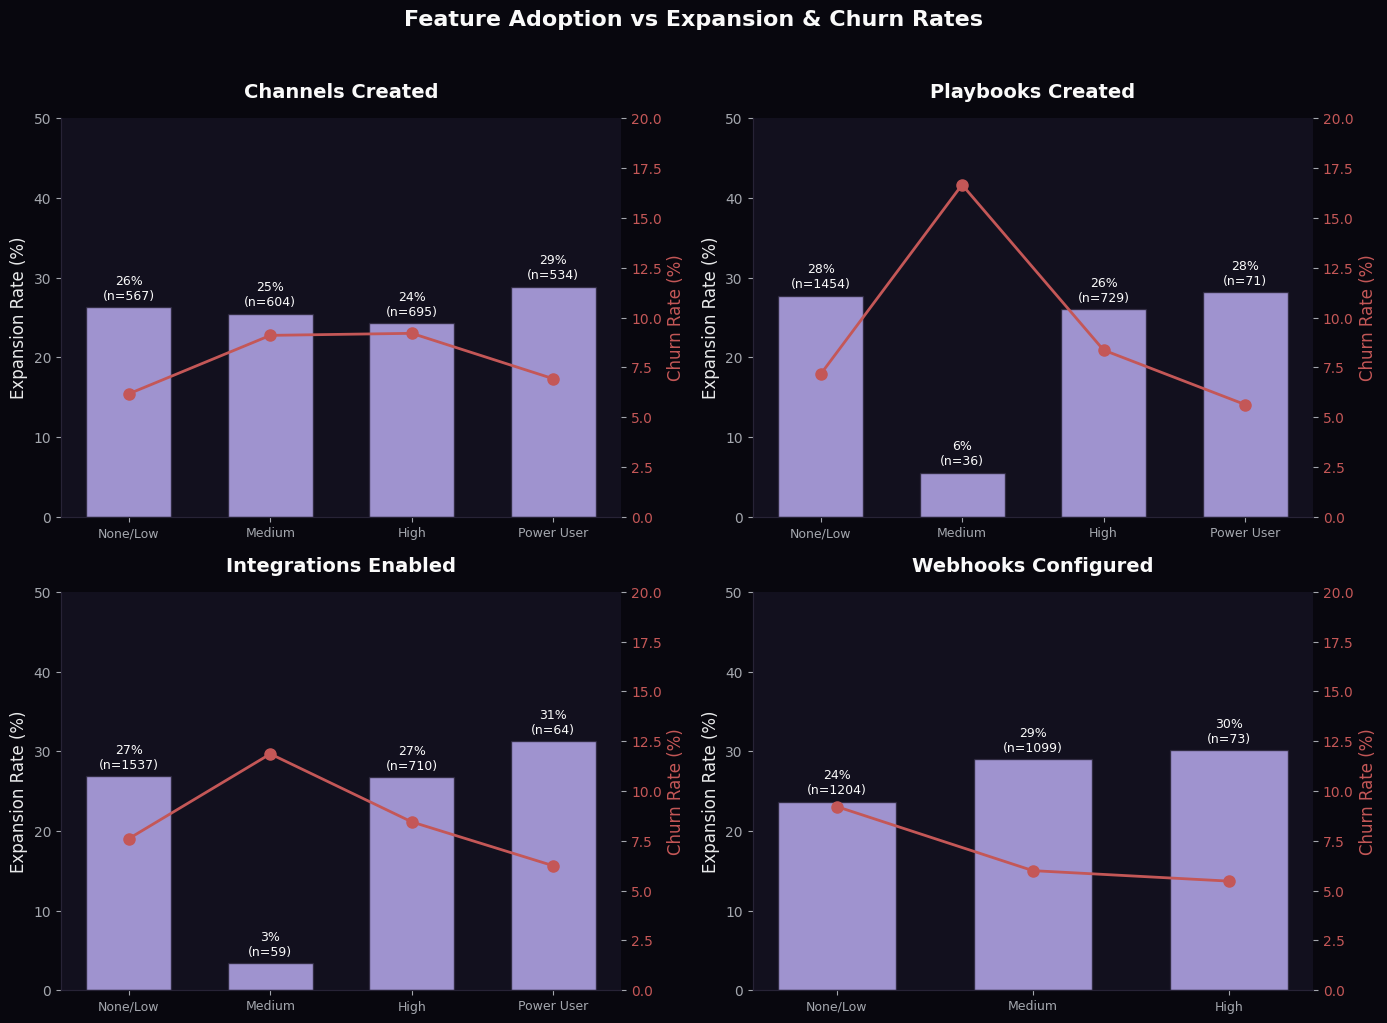


📊 Feature-Expansion Correlations:

  Webhooks Configured: +0.089 ↑ (Weak)
  Channels Created: +0.026 ↑ (Weak)
  Integrations Enabled: +0.024 ↑ (Weak)
  Playbooks Created: +0.011 ↑ (Weak)


In [12]:
# Deep dive: Feature adoption correlation with expansion
# Create feature adoption tiers and calculate expansion rates

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Use direct color codes since COLORS dict may be limited
RED = '#c45757'

features_analysis = [
    ('channels_count', 'Channels Created', [0, 10, 50, 200, 1000000]),
    ('playbooks_created', 'Playbooks Created', [0, 1, 3, 10, 1000]),
    ('integrations_enabled', 'Integrations Enabled', [0, 1, 2, 5, 100]),
    ('webhooks_configured', 'Webhooks Configured', [0, 1, 2, 5, 100])
]

correlations = {}

for idx, (feature, label, bins) in enumerate(features_analysis):
    ax = axes[idx // 2, idx % 2]
    
    # Create adoption tiers
    tier_labels = ['None/Low', 'Medium', 'High', 'Power User']
    subs_with_usage[f'{feature}_tier'] = pd.cut(subs_with_usage[feature], bins=bins, labels=tier_labels[:len(bins)-1])
    
    # Calculate expansion rate by tier
    tier_stats = subs_with_usage.groupby(f'{feature}_tier', observed=True).agg({
        'expanded': ['mean', 'count'],
        'churned': 'mean'
    }).reset_index()
    tier_stats.columns = ['tier', 'expansion_rate', 'count', 'churn_rate']
    tier_stats['expansion_rate'] *= 100
    tier_stats['churn_rate'] *= 100
    
    # Plot expansion rate by tier
    x = np.arange(len(tier_stats))
    bars = ax.bar(x, tier_stats['expansion_rate'], color=COLORS['primary'], width=0.6, edgecolor='#272336', alpha=0.8)
    
    # Add churn rate as line
    ax2 = ax.twinx()
    ax2.plot(x, tier_stats['churn_rate'], color=RED, marker='o', linewidth=2, markersize=8, label='Churn Rate')
    ax2.set_ylabel('Churn Rate (%)', color=RED)
    ax2.tick_params(axis='y', labelcolor=RED)
    ax2.set_ylim(0, 20)
    
    ax.set_xticks(x)
    ax.set_xticklabels(tier_stats['tier'], fontsize=9)
    ax.set_ylabel('Expansion Rate (%)')
    ax.set_title(f'{label}', fontweight='bold', pad=15)
    ax.set_ylim(0, 50)
    
    # Add count labels
    for bar, count, rate in zip(bars, tier_stats['count'], tier_stats['expansion_rate']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.0f}%\n(n={count})', ha='center', fontsize=9)
    
    # Calculate correlation
    corr = subs_with_usage[[feature, 'expanded']].corr().iloc[0, 1]
    correlations[label] = corr

plt.suptitle('Feature Adoption vs Expansion & Churn Rates', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print correlation summary
print("\n📊 Feature-Expansion Correlations:\n")
for feat, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    direction = "↑" if corr > 0 else "↓"
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.15 else "Weak"
    print(f"  {feat}: {corr:+.3f} {direction} ({strength})")

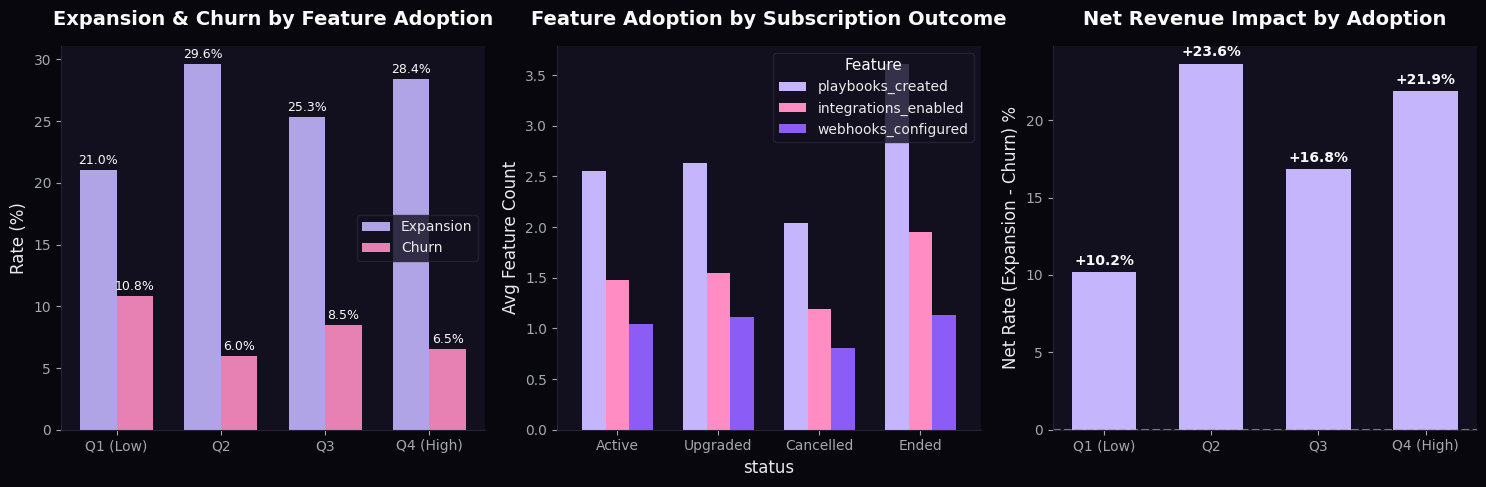


📊 Adoption Quartile Summary:

 Quartile Expansion Rate Churn Rate Avg ARR  Count  Net Rate
 Q1 (Low)          21.0%      10.8% $10,859    600 10.166667
       Q2          29.6%       6.0% $12,814    601 23.627288
       Q3          25.3%       8.5% $25,937    600 16.833333
Q4 (High)          28.4%       6.5% $33,475    599 21.869783

📈 Statistical Test (Q4 vs Q1 expansion): p-value = 0.0015 ✓ Significant


In [13]:
# Deeper analysis: Combined feature adoption score and expansion/churn outcomes
from scipy import stats

# Create composite feature adoption score (normalized)
for feat in ['channels_count', 'playbooks_created', 'integrations_enabled', 'webhooks_configured']:
    subs_with_usage[f'{feat}_norm'] = (subs_with_usage[feat] - subs_with_usage[feat].min()) / (subs_with_usage[feat].max() - subs_with_usage[feat].min())

subs_with_usage['adoption_score'] = (
    subs_with_usage['channels_count_norm'] * 0.25 +
    subs_with_usage['playbooks_created_norm'] * 0.25 +
    subs_with_usage['integrations_enabled_norm'] * 0.25 +
    subs_with_usage['webhooks_configured_norm'] * 0.25
)

# Create adoption quartiles
subs_with_usage['adoption_quartile'] = pd.qcut(subs_with_usage['adoption_score'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

# Analyze outcomes by adoption quartile
quartile_analysis = subs_with_usage.groupby('adoption_quartile', observed=True).agg({
    'expanded': 'mean',
    'churned': 'mean',
    'arr_usd': 'mean',
    'customer_id': 'count'
}).reset_index()
quartile_analysis.columns = ['Quartile', 'Expansion Rate', 'Churn Rate', 'Avg ARR', 'Count']
quartile_analysis['Expansion Rate'] *= 100
quartile_analysis['Churn Rate'] *= 100

# Statistical test: expansion rate Q4 vs Q1
q1_expanded = subs_with_usage[subs_with_usage['adoption_quartile'] == 'Q1 (Low)']['expanded']
q4_expanded = subs_with_usage[subs_with_usage['adoption_quartile'] == 'Q4 (High)']['expanded']
chi2_stat, p_value = stats.mannwhitneyu(q1_expanded, q4_expanded, alternative='less')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Expansion & Churn by Adoption Quartile
ax1 = axes[0]
x = np.arange(4)
width = 0.35
bars1 = ax1.bar(x - width/2, quartile_analysis['Expansion Rate'], width, color=COLORS['primary'], label='Expansion', alpha=0.9)
bars2 = ax1.bar(x + width/2, quartile_analysis['Churn Rate'], width, color=COLORS['secondary'], label='Churn', alpha=0.9)
ax1.set_xticks(x)
ax1.set_xticklabels(quartile_analysis['Quartile'])
ax1.set_ylabel('Rate (%)')
ax1.set_title('Expansion & Churn by Feature Adoption', fontweight='bold', pad=15)
ax1.legend()
for bars in [bars1, bars2]:
    for bar in bars:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{bar.get_height():.1f}%', 
                 ha='center', fontsize=9)

# 2. Feature adoption by outcome
ax2 = axes[1]
outcome_features = subs_with_usage.groupby('status')[['playbooks_created', 'integrations_enabled', 'webhooks_configured']].mean()
outcome_features = outcome_features.loc[['active', 'upgraded', 'cancelled', 'ended']]
outcome_features.plot(kind='bar', ax=ax2, color=[COLORS['primary'], COLORS['secondary'], COLORS['tertiary']], width=0.7)
ax2.set_xticklabels(['Active', 'Upgraded', 'Cancelled', 'Ended'], rotation=0)
ax2.set_ylabel('Avg Feature Count')
ax2.set_title('Feature Adoption by Subscription Outcome', fontweight='bold', pad=15)
ax2.legend(title='Feature', loc='upper right')

# 3. Net Revenue Impact
ax3 = axes[2]
# Calculate net revenue position by quartile
quartile_analysis['Net Rate'] = quartile_analysis['Expansion Rate'] - quartile_analysis['Churn Rate']
colors_net = [COLORS['primary'] if v > 0 else COLORS['secondary'] for v in quartile_analysis['Net Rate']]
bars = ax3.bar(quartile_analysis['Quartile'], quartile_analysis['Net Rate'], color=colors_net, width=0.6)
ax3.axhline(y=0, color='#a4a7ae', linestyle='--', alpha=0.7)
ax3.set_ylabel('Net Rate (Expansion - Churn) %')
ax3.set_title('Net Revenue Impact by Adoption', fontweight='bold', pad=15)
for bar, val in zip(bars, quartile_analysis['Net Rate']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:+.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Adoption Quartile Summary:\n")
print(quartile_analysis.to_string(index=False, formatters={
    'Expansion Rate': '{:.1f}%'.format,
    'Churn Rate': '{:.1f}%'.format,
    'Avg ARR': '${:,.0f}'.format
}))
print(f"\n📈 Statistical Test (Q4 vs Q1 expansion): p-value = {p_value:.4f} {'✓ Significant' if p_value < 0.05 else '✗ Not significant'}")

In [14]:
# Load deals data to analyze competitive win/loss rates
deals = pd.read_sql("SELECT * FROM deals", engine)
print(f"Total deals: {len(deals):,}")
print(f"\nOutcome breakdown:\n{deals['outcome'].value_counts()}")
print(f"\nCompetitors:\n{deals['competitor'].value_counts()}")
print(f"\nDeal stages:\n{deals['stage'].value_counts()}")

Total deals: 800

Outcome breakdown:
outcome
lost    432
won     248
open    120
Name: count, dtype: int64

Competitors:
competitor
slack          236
teams          195
none           162
google_chat     64
discord         43
webex           40
rocket_chat     33
other           27
Name: count, dtype: int64

Deal stages:
stage
closed_lost      432
closed_won       248
qualification     40
negotiation       33
proposal          24
prospecting       23
Name: count, dtype: int64


In [15]:
# Analyze competitive win/loss rates by competitor and customer segment
# Merge deals with customer data to get segment info
deals_with_customers = deals.merge(
    customers.rename(columns={'id': 'customer_id'}), 
    on='customer_id', 
    how='left'
)

# Add size tier
def get_size_tier(emp):
    if pd.isna(emp): return 'Unknown'
    if emp < 100: return 'SMB (<100)'
    if emp <= 500: return 'Mid-Market (100-500)'
    return 'Enterprise (500+)'

deals_with_customers['size_tier'] = deals_with_customers['employee_count'].apply(get_size_tier)

# Filter to closed deals only (won or lost) and main competitors
closed_deals = deals_with_customers[deals_with_customers['outcome'].isin(['won', 'lost'])].copy()
main_competitors = ['slack', 'teams', 'none', 'google_chat']
competitive_deals = closed_deals[closed_deals['competitor'].isin(main_competitors)].copy()

# Calculate win rates by competitor
win_by_competitor = competitive_deals.groupby('competitor').agg({
    'outcome': lambda x: (x == 'won').sum(),
    'id': 'count',
    'acv_usd': 'mean'
}).reset_index()
win_by_competitor.columns = ['Competitor', 'Wins', 'Total Deals', 'Avg ACV']
win_by_competitor['Win Rate'] = win_by_competitor['Wins'] / win_by_competitor['Total Deals'] * 100
win_by_competitor = win_by_competitor.sort_values('Total Deals', ascending=False)

print("📊 Win Rate by Competitor:\n")
print(win_by_competitor.to_string(index=False, formatters={
    'Win Rate': '{:.1f}%'.format,
    'Avg ACV': '${:,.0f}'.format
}))

📊 Win Rate by Competitor:

 Competitor  Wins  Total Deals Avg ACV Win Rate
      slack    83          204 $33,101    40.7%
      teams    56          170 $27,569    32.9%
       none    53          136 $28,241    39.0%
google_chat    19           54 $37,346    35.2%


/var/folders/yj/2fhp0frx3z5ct5ktb9z_43l40000gn/T/ipykernel_63205/2401938513.py:80: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  acv_win_rates = slack_teams.pivot_table(


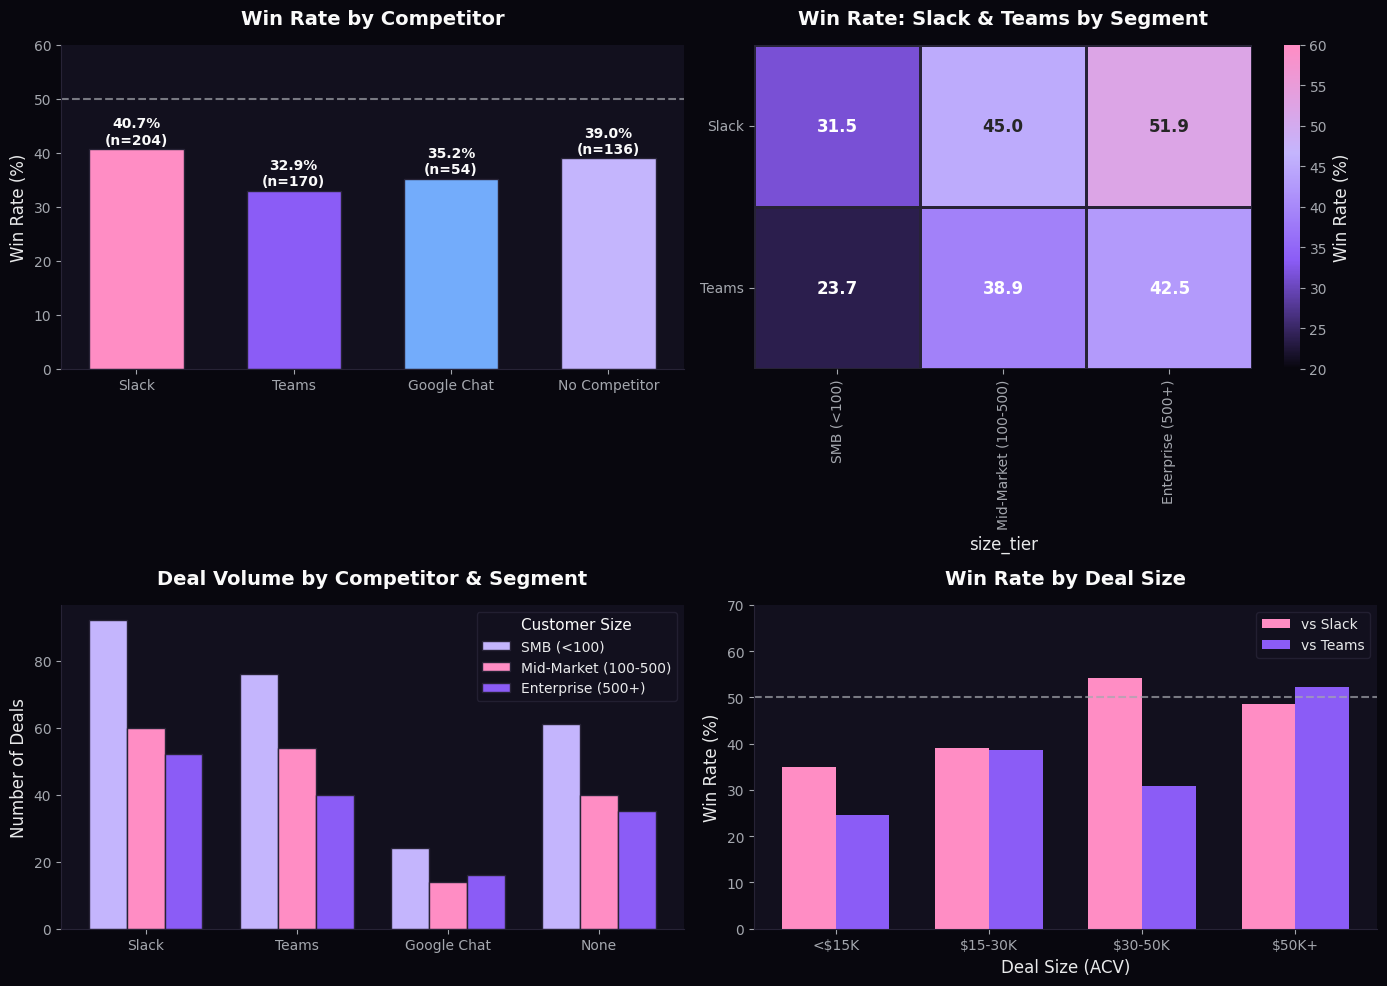


📊 Detailed Win Rate Analysis:


VS SLACK
Overall Win Rate: 40.7% (204 deals)

By Customer Size:
  SMB (<100): 31.5% (n=92)
  Mid-Market (100-500): 45.0% (n=60)
  Enterprise (500+): 51.9% (n=52)

VS TEAMS
Overall Win Rate: 32.9% (170 deals)

By Customer Size:
  SMB (<100): 23.7% (n=76)
  Mid-Market (100-500): 38.9% (n=54)
  Enterprise (500+): 42.5% (n=40)


In [16]:
# Detailed competitive analysis by customer segment
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Win Rate by Competitor (main chart)
ax1 = axes[0, 0]
competitors_order = ['slack', 'teams', 'google_chat', 'none']
competitor_labels = ['Slack', 'Teams', 'Google Chat', 'No Competitor']
win_rates = []
deal_counts = []

for comp in competitors_order:
    subset = competitive_deals[competitive_deals['competitor'] == comp]
    win_rate = (subset['outcome'] == 'won').mean() * 100
    win_rates.append(win_rate)
    deal_counts.append(len(subset))

x = np.arange(len(competitors_order))
bars = ax1.bar(x, win_rates, color=[COLORS['secondary'], COLORS['tertiary'], '#73acfb', COLORS['primary']], 
               width=0.6, edgecolor='#272336')
ax1.axhline(y=50, color='#a4a7ae', linestyle='--', alpha=0.7, label='50% baseline')
ax1.set_xticks(x)
ax1.set_xticklabels(competitor_labels)
ax1.set_ylabel('Win Rate (%)')
ax1.set_ylim(0, 60)
ax1.set_title('Win Rate by Competitor', fontweight='bold', pad=15)

for bar, rate, count in zip(bars, win_rates, deal_counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%\n(n={count})', ha='center', fontsize=10, fontweight='bold')

# 2. Win Rate by Competitor AND Customer Size
ax2 = axes[0, 1]
size_order = ['SMB (<100)', 'Mid-Market (100-500)', 'Enterprise (500+)']
pivot_data = competitive_deals.pivot_table(
    index='competitor', 
    columns='size_tier', 
    values='outcome',
    aggfunc=lambda x: (x == 'won').mean() * 100
)[size_order]
pivot_data = pivot_data.loc[['slack', 'teams']]  # Focus on main competitors

from matplotlib.colors import LinearSegmentedColormap
sp_cmap = LinearSegmentedColormap.from_list('signalpilot', ['#08070e', '#8b5cf6', '#c4b5fd', '#ff8dc4'])
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap=sp_cmap, ax=ax2,
            cbar_kws={'label': 'Win Rate (%)'}, annot_kws={'fontsize': 12, 'fontweight': 'bold'},
            linewidths=2, linecolor='#272336', vmin=20, vmax=60)
ax2.set_title('Win Rate: Slack & Teams by Segment', fontweight='bold', pad=15)
ax2.set_ylabel('')
ax2.set_yticklabels(['Slack', 'Teams'], rotation=0)

# 3. Deal Volume by Competitor and Segment (stacked bar)
ax3 = axes[1, 0]
volume_pivot = competitive_deals.pivot_table(
    index='competitor', 
    columns='size_tier', 
    values='id',
    aggfunc='count'
)[size_order].fillna(0)
volume_pivot = volume_pivot.loc[['slack', 'teams', 'google_chat', 'none']]

x = np.arange(len(volume_pivot))
width = 0.25
for i, size in enumerate(size_order):
    ax3.bar(x + i*width, volume_pivot[size], width, 
            color=CATEGORICAL_PALETTE[i], label=size, edgecolor='#272336')

ax3.set_xticks(x + width)
ax3.set_xticklabels(['Slack', 'Teams', 'Google Chat', 'None'])
ax3.set_ylabel('Number of Deals')
ax3.set_title('Deal Volume by Competitor & Segment', fontweight='bold', pad=15)
ax3.legend(title='Customer Size', loc='upper right')

# 4. Win Rate Trend - Slack vs Teams (by ACV tier)
ax4 = axes[1, 1]
competitive_deals['acv_tier'] = pd.cut(competitive_deals['acv_usd'], 
                                        bins=[0, 15000, 30000, 50000, 1000000],
                                        labels=['<$15K', '$15-30K', '$30-50K', '$50K+'])

slack_teams = competitive_deals[competitive_deals['competitor'].isin(['slack', 'teams'])]
acv_win_rates = slack_teams.pivot_table(
    index='acv_tier', 
    columns='competitor', 
    values='outcome',
    aggfunc=lambda x: (x == 'won').mean() * 100
)

x = np.arange(len(acv_win_rates))
width = 0.35
ax4.bar(x - width/2, acv_win_rates['slack'], width, color=COLORS['secondary'], label='vs Slack')
ax4.bar(x + width/2, acv_win_rates['teams'], width, color=COLORS['tertiary'], label='vs Teams')
ax4.axhline(y=50, color='#a4a7ae', linestyle='--', alpha=0.7)
ax4.set_xticks(x)
ax4.set_xticklabels(acv_win_rates.index)
ax4.set_ylabel('Win Rate (%)')
ax4.set_xlabel('Deal Size (ACV)')
ax4.set_title('Win Rate by Deal Size', fontweight='bold', pad=15)
ax4.legend()
ax4.set_ylim(0, 70)

plt.tight_layout()
plt.show()

# Summary stats
print("\n📊 Detailed Win Rate Analysis:\n")
for comp in ['slack', 'teams']:
    print(f"\n{'='*50}")
    print(f"VS {comp.upper()}")
    print(f"{'='*50}")
    subset = competitive_deals[competitive_deals['competitor'] == comp]
    overall_wr = (subset['outcome'] == 'won').mean() * 100
    print(f"Overall Win Rate: {overall_wr:.1f}% ({len(subset)} deals)")
    
    print("\nBy Customer Size:")
    for size in size_order:
        size_subset = subset[subset['size_tier'] == size]
        if len(size_subset) > 0:
            wr = (size_subset['outcome'] == 'won').mean() * 100
            print(f"  {size}: {wr:.1f}% (n={len(size_subset)})")